# CLIP and CROP

**Zero shot cropping of sections from images**

In this below tutorial, we have attempted to extract cropped out sections from image using the checkpoints of CLIP and YOLOS models hosted on HuggingFace hub. Generally to crop out sections from an image we need to manually select the section, but here we have attempted to extract sections just by using text descriptions. 

[**CLIP:**](https://huggingface.co/docs/transformers/model_doc/clip)

CLIP is a multi-modal model that leverages the semantics between an image and a textual description. CLIP has a lot of extended applications apart from simple image classification. It is even the catalyst to the famous image generation model DALL-E. We can extend CLIP to object detection, object tracking, image ranking, similarity search, and many more depending on our creativity etc. CLIP is a huge breakthrough as it paved way for a lot of research in the multi-modal domain of AI.

[**YOLOS:**](https://huggingface.co/docs/transformers/model_doc/yolos)

YOLOS - You only look at one sequence, an adoptation of YOLO on the plain Vision Transformer (ViT) for object detection, inspired by DETR. It is seen that YOLOS-Base directly adopted from BERT-Base architecture can obtain 42.0 box AP on COCO object detection benchmark.

## Loading the modules

In [1]:
import os
import torch
import warnings
import requests
import PIL
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, YolosImageProcessor, YolosForObjectDetection

In [2]:
warnings.simplefilter("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

## Implementation

### Model loading 

The following code blocks downloads the relevant model checkpoints from HuggingFace hub (YOLOS and CLIP respectively for object detection and semantic matching of images and text descriptions)

In [3]:
DETECTION_MODEL_NAME = "hustvl/yolos-tiny"
MULTIMODAL_MODEL_NAME = "openai/clip-vit-base-patch16"

**Loading YOLOS model**

In [4]:
det_image_processor = YolosImageProcessor.from_pretrained(DETECTION_MODEL_NAME)
det_model = YolosForObjectDetection.from_pretrained(DETECTION_MODEL_NAME)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


**Loading the CLIP model**

In [5]:
mm_model = CLIPModel.from_pretrained(MULTIMODAL_MODEL_NAME)
mm_processor = CLIPProcessor.from_pretrained(MULTIMODAL_MODEL_NAME)

### Implementation using loaded modules from HuggingFace hub

The following code blocks dowloads an image and loads it as a PIL Image

In [6]:
url = "https://i.pinimg.com/736x/1b/51/42/1b5142c269f2e9a356202af3f5569a87.jpg"
image = Image.open(requests.get(url, stream=True).raw)

**Code blocks implementing functions responsible for cropping and extraction of images.**

* The *extract_list_images_detected* function detects the objects with confidence scores above the given threshold
* The *extract_image_with_description* function semantically matches with the list of extracted images and descriptions

In [7]:
def extract_list_images_detected(image, prob):
    """
    The function `extract_list_images_detected` takes an image and a probability threshold as input,
    performs object detection on the image using a pre-trained model, and returns a list of cropped
    images of the detected objects along with their corresponding scores.
    
    Args:
    :param image: The `image` parameter is the input image from which you want to extract the detected
    images. It should be a PIL image object
    :param prob: The parameter "prob" is the probability threshold for filtering out the detected
    objects. It is used to determine which objects are considered significant enough to be included in
    the final list of images. Objects with a probability score higher than the threshold will be
    included, while objects with a lower score will be filtered out
    
    Returns:
    images_list: returns a list of cropped out images. 
    scores: returns a list of confidence scores corresponding scores. 
    """
    
    inputs = det_image_processor(images=image, return_tensors="pt")
    outputs = det_model(**inputs)
    
    logits = outputs.logits
    bboxes = outputs.pred_boxes
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    
    keep = probas.max(-1).values > prob
    outs = det_image_processor.post_process(outputs, torch.tensor(image.size[::-1]).unsqueeze(0))
    bboxes_scaled = outs[0]['boxes'][keep].detach().numpy()
    labels = outs[0]['labels'][keep].detach().numpy()
    scores = outs[0]['scores'][keep].detach().numpy()
    
    images_list = []
    for i,j in enumerate(bboxes_scaled):
        xmin = int(j[0])
        ymin = int(j[1])
        xmax = int(j[2])
        ymax = int(j[3])
    
        im_arr = np.array(image)
        roi = im_arr[ymin:ymax, xmin:xmax]
        roi_im = Image.fromarray(roi)
        images_list.append(roi_im)
    
    return images_list, scores

In [8]:
def extract_image_with_description(images_list, text, scores):
    """
    The function `extract_image_with_description` takes a list of images, a text description, and
    scores, and returns the image with the highest score.
    
    Args: 
    images_list: The `images_list` parameter is a list of images. Each image can be represented
    as a file path or a URL
    text: The `text` parameter is a string that represents the description or caption of the
    image
    scores: The "scores" parameter is a list of scores corresponding to each image in the
    "images_list". These scores represent the confidence or relevance of each image to the given text
    
    Returns: 
    the image with the highest score (PIL.Image) and its corresponding score.
    """
    
    input_ = mm_processor(text = [text], images=images_list , return_tensors="pt", padding=True)
    output = mm_model(**input_)
    logits_per_image = output.logits_per_text
    probs = logits_per_image.softmax(-1)
    l_idx = np.argsort(probs[-1].detach().numpy())[::-1][0:1]
    
    final_ims = []
    for i,j in enumerate(images_list):
        param_dict = {}
        if i in l_idx:
            param_dict['image'] = images_list[i]
            param_dict['score'] = probs[-1].detach().numpy()[i]
            final_ims.append(param_dict)
    
    fi = sorted(final_ims, key=lambda item: item.get("score"), reverse=True)
    return fi[0]['image'], fi[0]['score']

## Object Detection using YOLOS

Gets the cropped list of sections of image along with their confidence scores

In [9]:
list_rois, conf_scores = extract_list_images_detected(image, prob=0.85)

`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.


## Extraction using CLIP

Viewing the input image using matplotlib

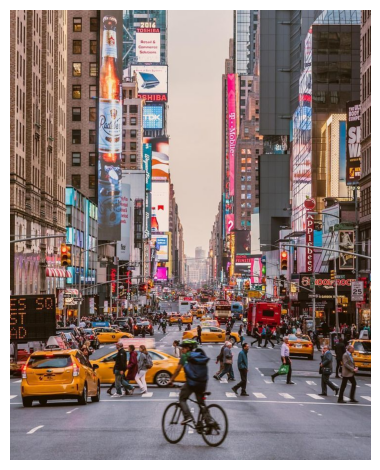

In [10]:
plt.imshow(image)
plt.axis("off")
plt.tight_layout()

Code blocks implementing semantic matching of images with provided descriptions. We provide a list of descriptions for which semantically matched images will be extracted and appended to a dictionary with relevant confidence scores.

In [11]:
TEXT_DESC = ["Man carrying a green bag", "man riding a bicycle", "yellow colored taxi car", "red colored bus"]
images_list = []
for txt in TEXT_DESC:
    img_dict = {}
    img, score = extract_image_with_description(list_rois, txt, conf_scores)
    img_dict['image'] = img
    img_dict['description'] = txt
    img_dict['conf-score'] = score
    images_list.append(img_dict)

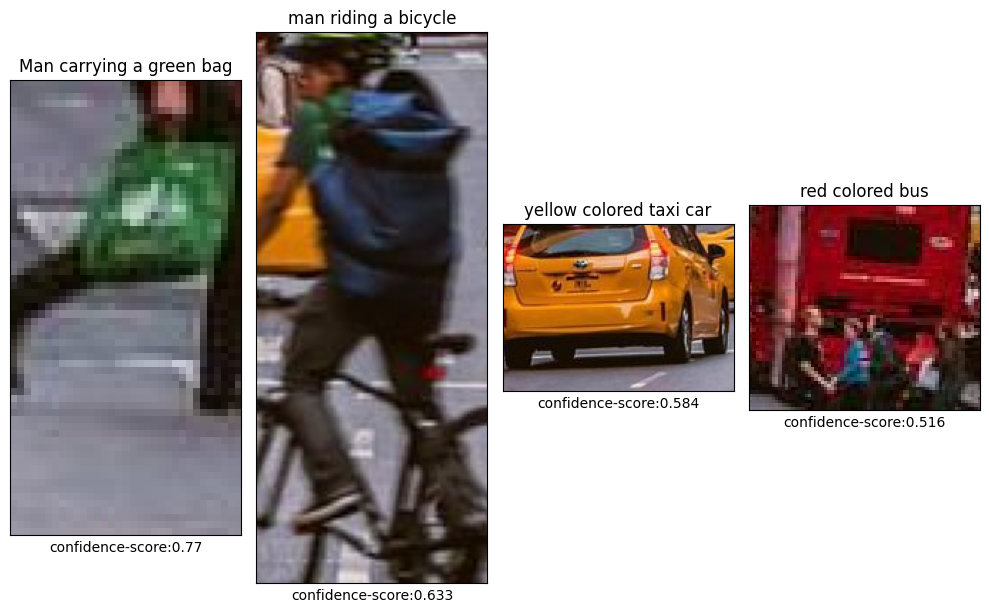

In [12]:
fig = plt.figure(figsize=(10, 20))
for i in range(len(images_list)):
    plt.subplot(1, len(images_list), i + 1)
    plt.imshow(images_list[i]['image'])
    plt.title(images_list[i]['description'])
    plt.xlabel("confidence-score:" + str(round(images_list[i]['conf-score'], 3)))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
plt.tight_layout()
plt.show()

## Conclusion

It can be seen that most of the cases could be really efficient as expected, but the drop in accuracy could be visible in other scenarios due to the fact we are leveraging smaller models for inference.